# Projeto NLP - Detectando Fake News (Noticias falsas)
Nesse projeto são apresentadas diferentes abordagens para detecção de noticias falsas.

# Motivação

No atual cenário de grande avanço tecnológico e uso das redes sociais em todas as camadas e classes sociais uma situação que causa problemas gráves é a divulgação de notícias falsas, pois essas podem prejucar a reputação de pessoas e organizações, e em casos mais gráves levar a linchamentos públicos.
Diante deste cenário, é de extrema importancia o desenvolvimento de métodos que consigam identificar possíveis noticias falsas para que seja possível tirá-las do ar.

Instalação das bibliotecas utilizadas

In [37]:
# !pip install -U scikit-learn
# !pip install pandas seaborn
# !pip install simpletransformers
# !pip install nltk
# !pip install tensorflow
# !pip install gensim

Importação das bibliotecas utilizaddas

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import nltk
import tensorflow as tf
from tensorflow import keras
from keras import layers

from sklearn import metrics
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split

from sklearn.svm import LinearSVC
from sklearn.metrics import accuracy_score

from datasets import load_dataset

from nltk.corpus import stopwords
from gensim.models import Doc2Vec
from gensim.models.doc2vec import TaggedDocument
from gensim import utils
import re
import string
import numpy as np

2024-03-28 16:10:36.178980: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
/Users/williansmagalhaesprimo/Library/Python/3.8/lib/python/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(
/Users/williansmagalhaesprimo/Library/Python/3.8/lib/python/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Configuração de display da biblioteca pandas

In [2]:
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.float_format', lambda x:'%.2f' %x)

# Lendo dados da base de dados 
<b>local de download:</b> Hugging faceFace

<b>url base 01:</b> https://huggingface.co/datasets/mrm8488/fake-news
<b>url base 02:</b> https://huggingface.co/datasets/fake_news_filipino

In [3]:
# Lendo os dados (base 01):
#with open('fake_news_data_set.json') as file:
#    data_set_json = json.load(file)
#
# Use pd.json_normalize to convert the JSON to a DataFrame
#df_news = pd.json_normalize(data_set_json['rows'], 
#                     meta=[['row', 'text'], ['row', 'label']])

df_news = load_dataset("mrm8488/fake-news")
df_news = pd.DataFrame(df_news['train'])

df_news.head()

,text,label
0,The Trump administration has been getting abso...,1
1,NAIROBI (Reuters) - Kenyan police shot dead tw...,0
2,PC is killing our country. This is called figh...,1
3,WASHINGTON (Reuters) - Republicans are poised ...,0
4,(Reuters) - A U.S. appeals court ruled on Frid...,0


In [5]:
# Detalhes da base
df_news.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 44898 entries, 0 to 44897
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    44898 non-null  object
 1   label   44898 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 701.7+ KB


In [6]:
# Colunas da base de dados
df_news.columns

Index(['text', 'label'], dtype='object')

In [7]:
# Validando a existência de dados nulos, no caso não existe
df_news.isnull().sum()

text     0
label    0
dtype: int64

In [8]:
# Validando a existência de dados na, no caso não existe
df_news.isna().sum()

text     0
label    0
dtype: int64

In [9]:
# Rótulos dos dados 0 - Notícia Real, 1 - Notícia falsa
df_news['label'].unique()

array([1, 0])

<Axes: xlabel='label', ylabel='count'>

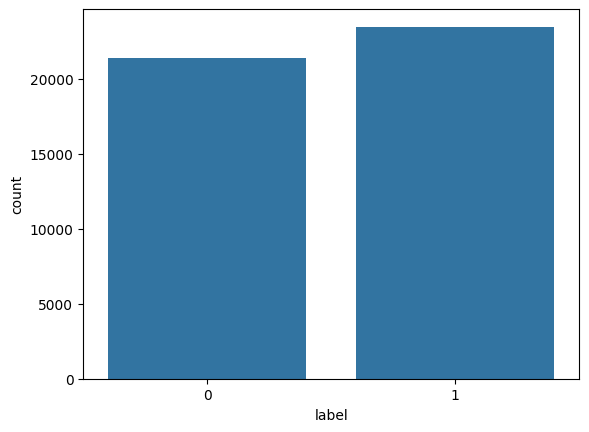

In [10]:
# Distribuição de positivos e negativos
sns.countplot(data=df_news, x='label')

Podemos observar que a base tem uma boa distribuição entre positivos e negativos, aproximadamente 50% para cada label.

# Preparando base para treinamento dos modelos
Separação em features e target

In [4]:
# Separando as features X e Y, treianemnto e teste
X = df_news['text']
Y = df_news['label']

X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=.2, random_state=42)

# Tokenization
Criando uma representação para o texto por meio de p método TFiDF

In [5]:
# Download de stopwords para limpeza de ruidos
nltk.download('stopwords')
sw_en = nltk.corpus.stopwords.words('english')
vectorizer = TfidfVectorizer(max_df=0.95, min_df=2, stop_words=sw_en)

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/williansmagalhaesprimo/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [13]:
# Aplicando a tokenização na base de treinamento
X_train_tfidf = vectorizer.fit_transform(X_train)
X_train_tfidf.shape

(35918, 65667)

# Modelo de NLP 01 - SVC
Nessa primeira abordagem será usado o SVC <b>Modelo de Linear Support Vector Classifier</b>.
Uma versão do SVN - Suport Vector Machine aplicado em tarefas de classificação

In [14]:
# Criação do modelo SVC:
svc = LinearSVC()
svc.fit(X_train_tfidf, y_train)

/Users/williansmagalhaesprimo/Library/Python/3.8/lib/python/site-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(


LinearSVC()

In [15]:
# Aplicando a tokenização na base de test
X_test_tfidf = vectorizer.transform(X_test)
X_test_tfidf.shape

(8980, 65667)

Testes e Métricas para o modelo SVC

In [16]:
# Teste do modelo SVC
prediction = svc.predict(X_test_tfidf)

# Verificando acurácia do modelo SVC
accuracy = accuracy_score(y_test, prediction)
print("Accuracy:", accuracy)

Accuracy: 0.9942093541202672


In [17]:
# Métricas para o modelo SVC (scores)
print(metrics.classification_report(y_test, prediction))

              precision    recall  f1-score   support

           0       0.99      0.99      0.99      4271
           1       0.99      0.99      0.99      4709

    accuracy                           0.99      8980
   macro avg       0.99      0.99      0.99      8980
weighted avg       0.99      0.99      0.99      8980



<Axes: >

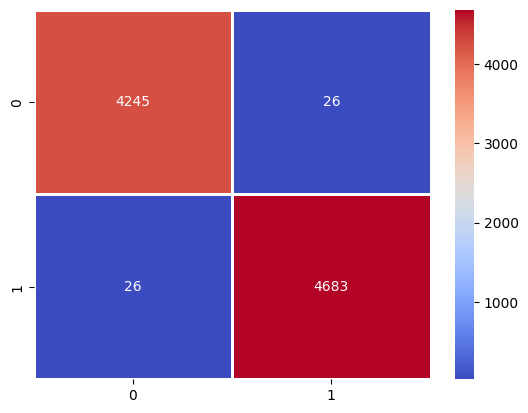

In [18]:
# Matriz de confusão
matriz_svc = metrics.confusion_matrix(y_test, prediction)
sns.heatmap(matriz_svc, cmap='coolwarm', annot=True, linewidth=1, fmt='d')

Como podemos ver, utilizando o modelo SVC jutamente com o método TFiDF apresentou um bom resultado, e com um equilibrio entre falsos positivos e falsos negativos.

# Modelo NLP 02 - Redes Neurais - feedforward (Sequencial)
Nessa segunda abordagem, iremos utilizar uma Rede neural Sequencial

In [6]:
vectorizer = TfidfVectorizer(max_df=0.95, min_df=2, stop_words=sw_en)
# Aplicando a tokenização na base de treinamento
X_train_tfidf = vectorizer.fit_transform(X_train)
X_train_tfidf = X_train_tfidf.toarray()
X_train_tfidf.shape

(35918, 65667)

In [7]:
# Criando o modelo de Rede Neural
# Tamanho da entrada
input_size = X_train_tfidf.shape[1]
net = keras.Sequential()
net.add(layers.Dense(32, input_shape=(input_size,)))
net.add(layers.Dropout(.2))
net.add(layers.Dense(16, activation = 'tanh'))
net.add(layers.Dense(1, activation = 'sigmoid'))
print(net.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 32)                2101376   
                                                                 
 dropout (Dropout)           (None, 32)                0         
                                                                 
 dense_1 (Dense)             (None, 16)                528       
                                                                 
 dense_2 (Dense)             (None, 1)                 17        
                                                                 
Total params: 2101921 (8.02 MB)
Trainable params: 2101921 (8.02 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
None


In [8]:
# Compilando o modelo de Rede Neural 
net.compile(
    loss='binary_crossentropy',
    optimizer="adam",
    metrics=["accuracy"],
)

In [9]:
# Treino do modelo
net.fit(X_train_tfidf, y_train, batch_size=16, epochs=2)

Epoch 1/2
2245/2245 [==============================] - 55s 24ms/step - loss: 0.0670 - accuracy: 0.9790
Epoch 2/2
2245/2245 [==============================] - 55s 25ms/step - loss: 0.0035 - accuracy: 0.9993


In [10]:
# Aplicando a tokenização na base de teste
X_test_tfidf = vectorizer.transform(X_test).toarray()
X_test_tfidf.shape

(8980, 65667)

In [11]:
# Teste do modelo Rede Neural
#prediction = net.evaluate(X_test_tfidf, y_test, batch_size = 1)
prediction = net.predict(X_test_tfidf)
prediction = [0 if p < 0.5 else 1 for p in prediction]
# Verificando acurácia do modelo Rede Neural
accuracy = accuracy_score(y_test, prediction)
print("Accuracy:", accuracy)

281/281 [==============================] - 1s 4ms/step
Accuracy: 0.9933184855233853


In [12]:
# Métricas para o modelo Rede Neural (scores)
print(metrics.classification_report(y_test, prediction))

              precision    recall  f1-score   support

           0       0.99      0.99      0.99      4271
           1       0.99      0.99      0.99      4709

    accuracy                           0.99      8980
   macro avg       0.99      0.99      0.99      8980
weighted avg       0.99      0.99      0.99      8980



<Axes: >

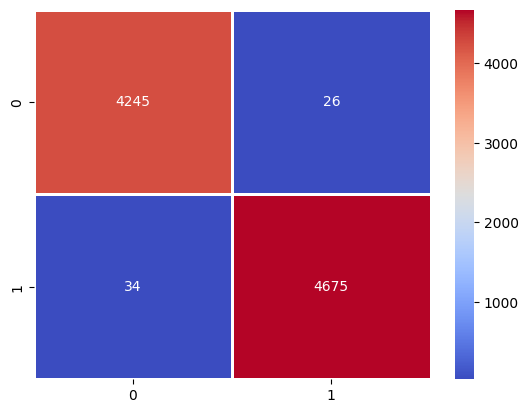

In [13]:
# Matriz de confusão
matriz_net = metrics.confusion_matrix(y_test, prediction)
sns.heatmap(matriz_net, cmap='coolwarm', annot=True, linewidth=1, fmt='d')

Com a utilização de uma Rede Neural Feedfoward também observa-se um bom desempenho. Uma matriz de confusão equilibrada entre acertos, erros falsos positivos e falsos negativos.

# Utilizando uma segunda base de dados para testes
Como foi utilizada uma base de dados pequena, aparentemente o modelo está apresentando overfiting, para validar essa possibilidade optou-se por usar uma segunda base apenas para teste e validar o grau de acerto e generalização do modelo.

In [14]:
# Lendo os dados (base 02):
df_news_02 = load_dataset("BeardedJohn/FakeNews")
df_news_02 = pd.DataFrame(df_news_02['train'])

df_news_02.head()

Generating train split: 10612 examples [00:00, 38434.36 examples/s]
Generating validation split: 3281 examples [00:00, 39622.22 examples/s]
Generating test split: 6735 examples [00:00, 45440.73 examples/s]


,label,text
0,0,democrat hillary clinton saturday receive firs...
1,1,former white house chief strategist stephen k....
2,1,dr. abdul el-sayed liberal democrat would like...
3,0,manila across asia countries pull beijing orbi...
4,1,clinton lynch talk grandkids top secret transc...


<Axes: xlabel='label', ylabel='count'>

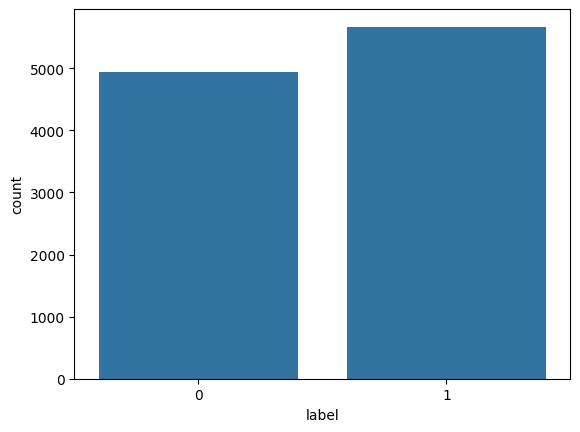

In [15]:
# Distribuição de positivos e negativos
sns.countplot(data=df_news_02, x='label')

In [16]:
# Aplicando a tokenização na base de teste 2
X_test_base_02 = df_news_02['text']
y_test_base_02 = df_news_02['label']
X_test_tfidf = vectorizer.transform(X_test_base_02).toarray()
X_test_tfidf.shape

(10612, 65667)

In [17]:
# Teste do modelo Rede Neural - Base 02
prediction = net.predict(X_test_tfidf)
prediction = [0 if p < 0.5 else 1 for p in prediction]
# Verificando acurácia do modelo Rede Neural
accuracy = accuracy_score(y_test_base_02, prediction)
print("Accuracy:", accuracy)

332/332 [==============================] - 2s 5ms/step
Accuracy: 0.9705993215228044


In [18]:
# Métricas para o modelo Rede Neural (scores)
print(metrics.classification_report(y_test_base_02, prediction))

              precision    recall  f1-score   support

           0       1.00      0.94      0.97      4942
           1       0.95      1.00      0.97      5670

    accuracy                           0.97     10612
   macro avg       0.97      0.97      0.97     10612
weighted avg       0.97      0.97      0.97     10612



<Axes: >

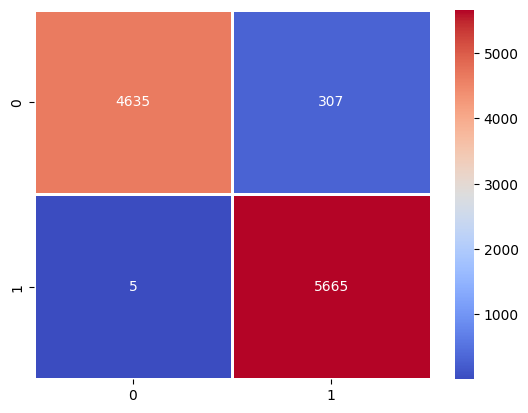

In [19]:
# Matriz de confusão
matriz_net = metrics.confusion_matrix(y_test_base_02, prediction)
sns.heatmap(matriz_net, cmap='coolwarm', annot=True, linewidth=1, fmt='d')

# Observação
Como podemos observar, mesmo aplicando os testes e uma base de "origem" diferente da base usada inicialmente para treinamento e testes o modelo de redes neurais apresentou uma boa taxa de acertos.
Mas é de se destacar que a quantidade de erros foi significativa se comparada com a base original usada no primeiro experimento.

## Testes utilizando Doc2Vec
A seguir será utilizada um método diferente para codificação da entrada para a rede, no caso será utilizado o mérodo Doc2Vec

In [20]:
# Funções para limpeza do texto
def constructLabeledSentences(data):
    sentences=[]
    for index, row in enumerate(data):
        sentences.append(TaggedDocument(utils.to_unicode(row).split(), ['Text' + '_%s' % str(index)]))
    return sentences

def textClean(text):
    text = re.sub(r"[^A-Za-z0-9^,!.\/'+-=]", " ", text)
    text = text.lower().split()
    stops = set(stopwords.words("english"))
    text = [w for w in text if not w in stops]    
    text = " ".join(text)
    return(text)
    
def cleanup(text):
    text = textClean(text)
    text= text.translate(str.maketrans("","", string.punctuation))
    return text


In [26]:
# Aplicando doc2Vec na base
model_size = 128
X_train_d2v = [cleanup(s) for s in X_train]
X_sentenses_d2v = constructLabeledSentences(X_train_d2v)
d2v = Doc2Vec(vector_size=model_size, min_count=2, epochs=5)
d2v.build_vocab(X_sentenses_d2v)
d2v.train(X_sentenses_d2v, total_examples=d2v.corpus_count, epochs=d2v.epochs)

In [27]:
# Aplicando doc2vec na base de teste
X_train_d2v = [d2v.infer_vector(s.split()) for s in X_train_d2v]
X_train_d2v = np.array([[c for c in l] for l in X_train_d2v])
X_train_d2v

array([[ 7.38614127e-02, -2.62592316e-01,  2.56651968e-01, ...,
        -2.28962168e-01,  3.90752815e-02, -1.68075949e-01],
       [ 1.23222426e-01,  2.41404586e-02, -1.40322328e-01, ...,
        -1.59566730e-01,  2.94167306e-02,  6.87906921e-01],
       [ 2.56584771e-03, -1.97579518e-01, -9.58446227e-03, ...,
         5.48803131e-04,  5.75304180e-02,  1.28912911e-01],
       ...,
       [ 2.41901860e-01,  1.08181909e-01,  2.82004029e-01, ...,
        -7.37183541e-02,  2.95439009e-02,  1.66295901e-01],
       [ 1.15146369e-01, -4.92875993e-01,  2.18963642e-02, ...,
         1.32037982e-01, -3.96674603e-01, -8.25920478e-02],
       [ 3.79442759e-02,  3.17659490e-02,  1.03535637e-01, ...,
        -1.06404334e-01, -5.99865764e-02, -3.08216661e-01]], dtype=float32)

In [28]:
# Criando o modelo de Rede Neural
net = keras.Sequential()
net.add(layers.Dense(128, input_shape=(model_size,)))
net.add(layers.Dropout(.2))
net.add(layers.Dense(32, activation = 'tanh'))
net.add(layers.Dense(1, activation = 'sigmoid'))
print(net.summary())


Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_6 (Dense)             (None, 128)               16512     
                                                                 
 dropout_2 (Dropout)         (None, 128)               0         
                                                                 
 dense_7 (Dense)             (None, 32)                4128      
                                                                 
 dense_8 (Dense)             (None, 1)                 33        
                                                                 
Total params: 20673 (80.75 KB)
Trainable params: 20673 (80.75 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
None


In [29]:
# Compilando o modelo de Rede Neural 
net.compile(
    loss='binary_crossentropy',
    optimizer="adam",
    metrics=["accuracy"],
)
# Treino do modelo
net.fit(X_train_d2v, y_train, batch_size=4, epochs=3)

Epoch 1/3
8980/8980 [==============================] - 10s 1ms/step - loss: 0.2535 - accuracy: 0.8952
Epoch 2/3
8980/8980 [==============================] - 9s 989us/step - loss: 0.2219 - accuracy: 0.9102
Epoch 3/3
8980/8980 [==============================] - 9s 980us/step - loss: 0.2062 - accuracy: 0.9171


In [30]:
# Aplicando doc2vec na base de teste
X_test_d2v = [cleanup(s) for s in X_test]
X_test_d2v = [d2v.infer_vector(s.split()) for s in X_test_d2v]
X_test_d2v = np.array([[c for c in l] for l in X_test_d2v])
X_test_d2v

array([[ 0.15097556, -0.1540671 ,  0.2390369 , ..., -0.19170432,
         0.05572138,  0.5165335 ],
       [ 0.38469887, -0.18539417,  0.7501429 , ..., -0.19049586,
        -0.21955562,  0.40933612],
       [ 0.05765236,  0.07405173,  0.14418198, ..., -0.09239028,
         0.00093817,  0.23732679],
       ...,
       [ 0.18549067,  0.2186656 ,  0.1208265 , ..., -0.40060854,
        -0.174127  ,  0.2420674 ],
       [ 0.05883452,  0.02182447,  0.1472018 , ...,  0.00571867,
         0.02777898,  0.07973416],
       [-0.24771132, -0.14122406, -0.10113282, ..., -0.2126457 ,
        -0.03897593,  0.2803236 ]], dtype=float32)

In [31]:
# Teste do modelo Rede Neural
prediction = net.predict(X_test_d2v)
prediction = [0 if p < 0.5 else 1 for p in prediction]
# Verificando acurácia do modelo Rede Neural
accuracy = accuracy_score(y_test, prediction)
print("Accuracy:", accuracy)

281/281 [==============================] - 0s 805us/step
Accuracy: 0.9232739420935412


In [32]:
# Aplicando doc2vec na base de teste (2)
X_test_d2v = [cleanup(s) for s in X_test_base_02]
X_test_d2v = [d2v.infer_vector(s.split()) for s in X_test_d2v]
X_test_d2v = np.array([[c for c in l] for l in X_test_d2v])
X_test_d2v

array([[ 0.12674877, -0.18858235, -0.05807608, ..., -0.14354594,
        -0.01250996,  0.02804925],
       [ 0.27449796, -0.1929446 ,  0.09660096, ..., -0.22470501,
         0.24257877,  0.31507394],
       [ 0.6738733 ,  0.44436404, -0.03732745, ..., -0.5195952 ,
         0.5379062 ,  0.21506235],
       ...,
       [ 0.11908599, -0.10716534, -0.51411104, ..., -0.5156779 ,
         0.46680734, -0.04034404],
       [ 0.51808834,  0.172968  ,  0.09188262, ..., -0.11208327,
         0.11090967,  0.44634932],
       [ 0.26654038,  0.01415094,  0.11050613, ..., -0.19827855,
         0.18542106,  0.54686517]], dtype=float32)

In [33]:
# Teste do modelo Rede Neural para a base (2)
prediction = net.predict(X_test_d2v)
prediction = [0 if p < 0.5 else 1 for p in prediction]
# Verificando acurácia do modelo Rede Neural
accuracy = accuracy_score(y_test_base_02, prediction)
print("Accuracy:", accuracy)

  1/332 [..............................] - ETA: 8s

332/332 [==============================] - 0s 890us/step
Accuracy: 0.9347908028646815


# Conclusão final
Com a aplicação de diferentes modelos e técnicas de representação de características textuais foi possível notar que é perfeitamente possível inditificar possíveis fakenews pela aplicação de algoritmos de inteligência artifica;.